In [8]:
import time
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import mplhep as hep

import pickle as pkl
import sys
sys.path.insert(0,'..')
from models import ParticleNet
import torch
import torch.nn as nn
from torch_geometric.loader import DataListLoader, DataLoader
from torch_geometric.data import Data, Batch

from networkx import draw_networkx_nodes, draw_networkx_edges

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
%matplotlib inline

import mplhep as hep
plt.style.use(hep.style.CMS)
plt.rcParams.update({'font.size': 20})

import awkward as ak
import fastjet
import vector

## Configuration

In [5]:
if torch.cuda.device_count():
    device = torch.device("cuda:0")
else:
    device = "cpu"
    
N_SUBJETS = 3

LABEL = {}
LABEL[fastjet.kt_algorithm] = "$k_{{\mathrm{{T}}}}$"
LABEL[fastjet.antikt_algorithm] = "anti-$k_{{\mathrm{{T}}}}$"
LABEL[fastjet.cambridge_algorithm] = "CA"

JET_ALGO = fastjet.kt_algorithm

jetdef = fastjet.JetDefinition(JET_ALGO, 0.8)

# Load Rscores

In [122]:
PATH = '/xai4hepvol/ParticleNet_6/best_epoch'

import networkx as nx
import torch
import torch_geometric
import numpy as np
import pickle as pkl

with open(f'{PATH}/batch_x.pkl', 'rb') as handle:
    batch_x_list = pkl.load(handle)
with open(f'{PATH}/batch_y.pkl', 'rb') as handle:
    batch_y_list = pkl.load(handle)    
# with open(f'{PATH}/Rscores.pkl', 'rb') as handle:
#     Rscores_list = pkl.load(handle)
with open(f'{PATH}/R_edges.pkl', 'rb') as handle:
    R_edges_list = pkl.load(handle)    
with open(f'{PATH}/edge_index.pkl', 'rb') as handle:
    edge_index_list = pkl.load(handle)
    
with open(f'{PATH}/batch_px.pkl', 'rb') as handle:
    batch_px_list = pkl.load(handle)
with open(f'{PATH}/batch_py.pkl', 'rb') as handle:
    batch_py_list = pkl.load(handle)  
with open(f'{PATH}/batch_pz.pkl', 'rb') as handle:
    batch_pz_list = pkl.load(handle)
with open(f'{PATH}/batch_E.pkl', 'rb') as handle:
    batch_E_list = pkl.load(handle)      

In [123]:
def get_subjets(px, py, pz, e):
    vector.register_awkward()
    px = ak.from_regular(ak.from_numpy(px.numpy()))
    py = ak.from_regular(ak.from_numpy(py.numpy()))
    pz = ak.from_regular(ak.from_numpy(pz.numpy()))
    e = ak.from_regular(ak.from_numpy(e.numpy()))

    # define jet directly not an array of jets
    jet = ak.zip(
        {
            "px": px,
            "py": py,
            "pz": pz,
            "E": e,
            "particle_idx": ak.local_index(px),
            "subjet_idx": ak.zeros_like(px, dtype=int) - 1,
        },
        with_name="Momentum4D",
    )

    pseudojets = []
    pseudojets.append(
        [
            fastjet.PseudoJet(particle.px, particle.py, particle.pz, particle.E)
            for particle in jet
        ]
    )

    subjet_indices = []
    mapping = [jet.subjet_idx.to_list()]   # added square brackets
    for ijet, pseudojet in enumerate(pseudojets):
        subjet_indices.append([])
        cluster = fastjet.ClusterSequence(pseudojet, jetdef)

        # cluster jets
        jets = cluster.inclusive_jets()
        assert len(jets) == 1

        # get the 3 exclusive jets
        subjets = cluster.exclusive_subjets(jets[0], N_SUBJETS)
        assert len(subjets) == N_SUBJETS

        # sort by pt
        subjets = sorted(subjets, key=lambda x: x.pt(), reverse=True)

        for subjet_idx, subjet in enumerate(subjets):
            subjet_indices[-1].append([])
            for subjet_const in subjet.constituents():
                for idx, jet_const in enumerate(pseudojet):
                    if (
                        subjet_const.px() == jet_const.px()
                        and subjet_const.py() == jet_const.py()
                        and subjet_const.pz() == jet_const.pz()
                        and subjet_const.E() == jet_const.E()
                    ):
                        subjet_indices[-1][-1].append(idx)

        for subjet_idx, subjet in enumerate(subjets):
            local_mapping = np.array(mapping[ijet])
            local_mapping[subjet_indices[ijet][subjet_idx]] = subjet_idx
            mapping[ijet] = local_mapping

    # update array
    # array.subjet_idx = ak.Array(mapping)
    jet = ak.zip(
        {
            "px": px,
            "py": py,
            "pz": pz,
            "E": e,
            "particle_idx": ak.local_index(px),
            "subjet_idx": ak.Array(mapping[0]), # pick first element
        },
        with_name="Momentum4D",
    )    

    jet_vector = vector.obj(
        px=ak.sum(jet.px, axis=-1),
        py=ak.sum(jet.py, axis=-1),
        pz=ak.sum(jet.pz, axis=-1),
        E=ak.sum(jet.E, axis=-1),
    )
    subjet_vectors = [
        vector.obj(
            px=ak.sum(jet.px[jet.subjet_idx == j], axis=-1),
            py=ak.sum(jet.py[jet.subjet_idx == j], axis=-1),
            pz=ak.sum(jet.pz[jet.subjet_idx == j], axis=-1),
            E=ak.sum(jet.E[jet.subjet_idx == j], axis=-1),
        )
        for j in range(0, N_SUBJETS)
    ]

    deta = jet.deltaeta(jet_vector)
    dphi = jet.deltaphi(jet_vector)
    dpt = jet.pt / jet_vector.pt
    
    subjet_idx = jet.subjet_idx.to_numpy()
    
    return subjet_idx, subjet_vectors, deta, dphi, dpt

Loading a trained model...
Testing a forward pass...
Building the Edge-Rgraph...
Plotting the Edge-Rgraph...


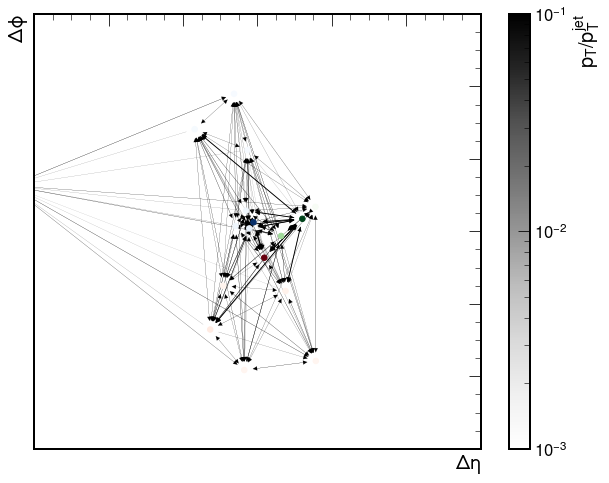

In [126]:
Num_jets = len(batch_px_list)
for i in range(Num_jets):
    if i!=0:
        continue

    jet_input = batch_x_list[i]
    jet_label = batch_y_list[i]
    
    R_edges = R_edges_list[i]
    edge_index_dic = edge_index_list[i]

    px = batch_px_list[i]
    py = batch_py_list[i]
    pz = batch_pz_list[i]
    e = batch_E_list[i]
    
    # get subjets
    subjet_idx, subjet_vectors, eta, phi, pt = get_subjets(px, py, pz, e)

    # load the trained model
    print('Loading a trained model...')    
    PATH = "/xai4hepvol/experiments/ParticleNet_6"

    with open(f"{PATH}/model_kwargs.pkl", "rb") as f:
        model_kwargs = pkl.load(f)

    state_dict = torch.load(f"{PATH}/best_epoch_weights.pth", map_location=device)

    model = ParticleNet(**model_kwargs)
    model.load_state_dict(state_dict)  
    
    # testing the score
    print('Testing a forward pass...')        
    sig = nn.Sigmoid()
    model_score = round(sig(model(Batch(x=jet_input, batch=torch.zeros(len(jet_input), dtype=int)))[0]).item(),3)            

    print('Building the Edge-Rgraph...')        
    # Get positions of nodes in the graph
    eta_phi = torch.cat([torch.tensor(eta).reshape(-1,1), torch.tensor(phi).reshape(-1,1)], axis=1)

    pos = {}
    num_nodes = len(px)
    for node_i in range(num_nodes):
        pos[node_i] = eta_phi.numpy()[node_i]

    # build graph
#     for edgeconv in ['edge_conv_2']:    
    edge_index, edge_weight = edge_index_dic, torch.abs(R_edges).sum(axis=1)
    edge_Rscores = edge_weight/sum(edge_weight)  # normalize sum of Rscores of all jets to be 1

    data = torch_geometric.data.Data(edge_index=edge_index, edge_weight=edge_weight, num_nodes=num_nodes)
    G = torch_geometric.utils.to_networkx(data, to_undirected=False)

    # subjet node colors
    COLOR_from_idx = ['Blues', 'Reds', 'Greens', 'Orange', 'Yellow', 'Purple']
    
    Num_subjets = len(np.unique(subjet_idx))
    COLOR_from_idx = COLOR_from_idx[:Num_subjets]
    
    print('Plotting the Edge-Rgraph...')        
    fig, ax = plt.subplots(figsize=(10, 8))
    for j in range(Num_subjets):
        draw_networkx_nodes(G, pos, 
                            nodelist=np.array(list(G))[subjet_idx==j].tolist(), 
                            node_color=10*pt[subjet_idx==j],
                            node_size=30,
                            cmap=COLOR_from_idx[j], 
                            ax=ax, 
                            label=f"{LABEL[JET_ALGO]} Subjet {j} $p_{{\mathrm{{T}}}}$={subjet_vectors[j].pt:.0f}",                        
                           )
    plt.scatter([], [], c=[], cmap="Greys", norm=colors.LogNorm(vmin=0.001, vmax=0.1))
    cbar = plt.colorbar()
    cbar.set_label("$p_{\mathrm{T}} / p_{\mathrm{T}}^{\mathrm{jet}}$")
#     ax.legend()    

    draw_networkx_edges(G, pos, 
                        width=40*(edge_Rscores),
                        edge_color='k', 
                        style='solid', 
                        arrowsize=10,
                        ax=ax, 
                       )

    plt.xlabel(r"$\Delta\eta$")
    plt.ylabel(r"$\Delta\phi$")
    plt.ylim(-0.6, 0.6)
    plt.xlim(-0.6, 0.6);
#     plt.legend(title="Top jet" if jet_label==1 else "QCD jet")
    # plt.savefig(f"etaphi_{i}.pdf")
#     plt.savefig(f"/xai4hepvol/test.pdf")    

    break

## Scaling up

In [269]:
PATH = '/xai4hepvol/ParticleNet_6/best_epoch'

import networkx as nx
import torch
import torch_geometric
import numpy as np
import pickle as pkl

with open(f'{PATH}/batch_x.pkl', 'rb') as handle:
    batch_x_list = pkl.load(handle)
with open(f'{PATH}/batch_y.pkl', 'rb') as handle:
    batch_y_list = pkl.load(handle)    
# with open(f'{PATH}/Rscores.pkl', 'rb') as handle:
#     Rscores_list = pkl.load(handle)
with open(f'{PATH}/R_edges.pkl', 'rb') as handle:
    R_edges_list = pkl.load(handle)    
with open(f'{PATH}/edge_index.pkl', 'rb') as handle:
    edge_index_list = pkl.load(handle)
    
with open(f'{PATH}/batch_px.pkl', 'rb') as handle:
    batch_px_list = pkl.load(handle)
with open(f'{PATH}/batch_py.pkl', 'rb') as handle:
    batch_py_list = pkl.load(handle)  
with open(f'{PATH}/batch_pz.pkl', 'rb') as handle:
    batch_pz_list = pkl.load(handle)
with open(f'{PATH}/batch_E.pkl', 'rb') as handle:
    batch_E_list = pkl.load(handle)  

from tqdm.notebook import tqdm

Top_N = 15

top_same = np.array([0] * Top_N)
top_diff = np.array([0] * Top_N)
qcd_same = np.array([0] * Top_N)
qcd_diff = np.array([0] * Top_N)

Num_jets = len(batch_px_list)
for i in tqdm(range(Num_jets)):
    jet_label = batch_y_list[i]
    
    R_edges = R_edges_list[i]
    edge_index_dic = edge_index_list[i]

    px = batch_px_list[i]
    py = batch_py_list[i]
    pz = batch_pz_list[i]
    e = batch_E_list[i]
    
    # get subjets
    try:
        subjet_idx, subjet_vectors, eta, phi, pt = get_subjets(px, py, pz, e)
    except:
        print(f"skipping jet # {i}")
        continue
        
    # top N edges
    edge_index, edge_weight = edge_index_dic, torch.abs(R_edges).sum(axis=1)
    edge_Rscores = edge_weight/sum(edge_weight)  # normalize sum of Rscores of all jets to be 1
    
    for N in range(Top_N):
        for edge in torch.topk(edge_Rscores, N+1).indices:   # N=0 doesn't make sense here
            if jet_label==1:
                if subjet_idx[edge_index[0][edge]]!=subjet_idx[edge_index[1][edge]]:
                    top_diff[N] += 1
                else:
                    top_same[N] += 1
            else:
                if subjet_idx[edge_index[0][edge]]!=subjet_idx[edge_index[1][edge]]:      
                    qcd_diff[N] += 1
                else:
                    qcd_same[N] += 1

  0%|          | 0/996 [00:00<?, ?it/s]

skipping jet # 25


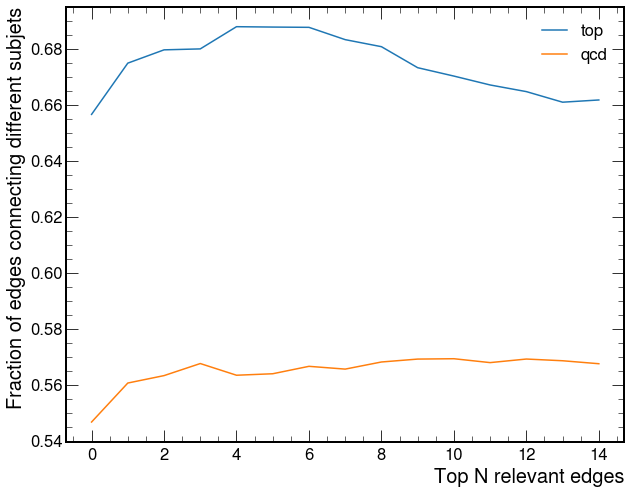

In [270]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(range(len(top_diff)), top_diff/(top_same+top_diff), label='top')
ax.plot(range(len(qcd_diff)), qcd_diff/(qcd_same+qcd_diff), label='qcd')

ax.set_xlabel(r"Top N relevant edges")
ax.set_ylabel(r"Fraction of edges connecting different subjets")
ax.legend()

In [275]:
PATH = '/xai4hepvol/ParticleNet_6/before_training'

import networkx as nx
import torch
import torch_geometric
import numpy as np
import pickle as pkl

with open(f'{PATH}/batch_x.pkl', 'rb') as handle:
    batch_x_list = pkl.load(handle)
with open(f'{PATH}/batch_y.pkl', 'rb') as handle:
    batch_y_list = pkl.load(handle)    
# with open(f'{PATH}/Rscores.pkl', 'rb') as handle:
#     Rscores_list = pkl.load(handle)
with open(f'{PATH}/R_edges.pkl', 'rb') as handle:
    R_edges_list = pkl.load(handle)    
with open(f'{PATH}/edge_index.pkl', 'rb') as handle:
    edge_index_list = pkl.load(handle)
    
with open(f'{PATH}/batch_px.pkl', 'rb') as handle:
    batch_px_list = pkl.load(handle)
with open(f'{PATH}/batch_py.pkl', 'rb') as handle:
    batch_py_list = pkl.load(handle)  
with open(f'{PATH}/batch_pz.pkl', 'rb') as handle:
    batch_pz_list = pkl.load(handle)
with open(f'{PATH}/batch_E.pkl', 'rb') as handle:
    batch_E_list = pkl.load(handle)  

In [281]:
from tqdm.notebook import tqdm

Top_N = 15

top_same = np.array([0] * Top_N)
top_diff = np.array([0] * Top_N)
qcd_same = np.array([0] * Top_N)
qcd_diff = np.array([0] * Top_N)

Num_jets = len(batch_px_list)
for i in tqdm(range(Num_jets)):
    jet_label = batch_y_list[i]
    
    R_edges = R_edges_list[i]
    edge_index_dic = edge_index_list[i]

    px = batch_px_list[i]
    py = batch_py_list[i]
    pz = batch_pz_list[i]
    e = batch_E_list[i]
    
    # get subjets
    try:
        subjet_idx, subjet_vectors, eta, phi, pt = get_subjets(px, py, pz, e)
    except:
        print(f"skipping jet # {i}")
        continue
        
    # top N edges
    edge_index, edge_weight = edge_index_dic, torch.abs(R_edges).sum(axis=1)
    edge_Rscores = edge_weight/sum(edge_weight)  # normalize sum of Rscores of all jets to be 1
    
    for N in range(Top_N):
        for edge in torch.topk(edge_Rscores, N+1).indices:   # N=0 doesn't make sense here
            if jet_label==1:
                if subjet_idx[edge_index[0][edge]]!=subjet_idx[edge_index[1][edge]]:
                    top_diff[N] += 1
                else:
                    top_same[N] += 1
            else:
                if subjet_idx[edge_index[0][edge]]!=subjet_idx[edge_index[1][edge]]:      
                    qcd_diff[N] += 1
                else:
                    qcd_same[N] += 1    
    if i==400:
        break

  0%|          | 0/989 [00:00<?, ?it/s]

skipping jet # 258


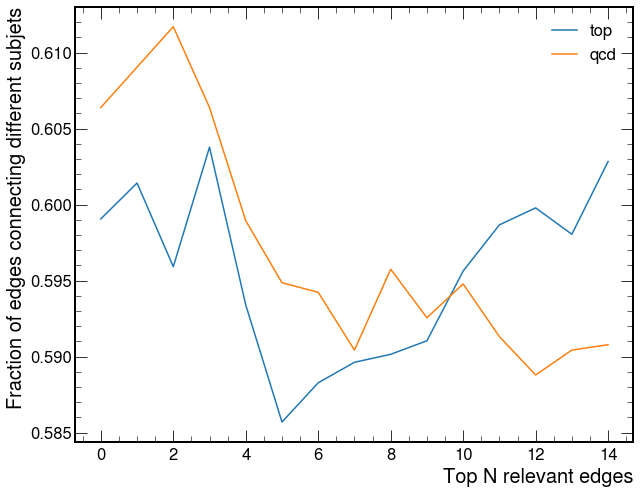

In [282]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(range(len(top_diff)), top_diff/(top_same+top_diff), label='top')
ax.plot(range(len(qcd_diff)), qcd_diff/(qcd_same+qcd_diff), label='qcd')

ax.set_xlabel(r"Top N relevant edges")
ax.set_ylabel(r"Fraction of edges connecting different subjets")
ax.legend()

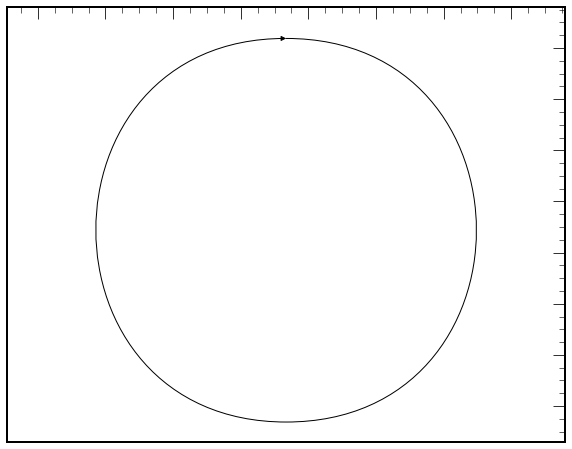

In [76]:
fig, ax = plt.subplots(figsize=(10, 8))
for j in range(Num_subjets):
    if j!=1:
        continue
#     draw_networkx_nodes(G, pos, 
#                         nodelist=np.array(list(G))[subjet_idx==j].tolist(), 
#                         node_color=10*pt[subjet_idx==j],
#                         node_size=30,
#                         cmap=COLOR_from_idx[j], 
#                         ax=ax, 
#                         label=f"{LABEL[JET_ALGO]} Subjet {j} $p_{{\mathrm{{T}}}}$={subjet_vectors[j].pt:.0f}",                        
#                        )
    draw_networkx_edges(G, pos,
#                     width=40*(edge_Rscores),
                    edgelist=list(G.edges)[268:269],
                    edge_color='k', 
                    style='solid', 
                    arrowsize=10,
                    ax=ax, 
                   )
# draw_networkx_edges(G, pos, 
#                     width=40*(edge_Rscores),
#                     edge_color='k', 
#                     style='solid', 
#                     arrowsize=10,
#                     ax=ax, 
#                    )

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors

fig = plt.figure(figsize=(8,8))        
for j, cmap in zip(range(0, N_SUBJETS), ["Blues", "Reds", "Greens", "Purples"]):
    plt.scatter(
        deta[jet.subjet_idx == j],
        dphi[jet.subjet_idx == j],
        c=dpt[jet.subjet_idx == j],
        s=10,
        norm=colors.LogNorm(vmin=0.001, vmax=0.1),
        cmap=cmap,

        label=f"{LABEL[JET_ALGO]} Subjet {j} $p_{{\mathrm{{T}}}}$={subjet_vectors[j].pt:.0f}",
    )    

plt.scatter([], [], c=[], cmap="Greys", norm=colors.LogNorm(vmin=0.001, vmax=0.1))
cbar = plt.colorbar()
cbar.set_label("$p_{\mathrm{T}} / p_{\mathrm{T}}^{\mathrm{jet}}$")
plt.xlabel(r"$\Delta\eta$")
plt.ylabel(r"$\Delta\phi$")
plt.ylim(-1.2, 1.2)
plt.xlim(-1.2, 1.2)
plt.legend(title="Top jet" if df["is_signal_new"].values[i] == 1 else "QCD jet")
plt.savefig(f"etaphi_{i}.pdf")
plt.savefig(f"etaphi_{i}.png")        
break

## LRP

In [48]:
PATH = '/xai4hepvol/ParticleNet_6/before_training'

import networkx as nx
import torch
import torch_geometric
import numpy as np
import pickle as pkl

with open(f'{PATH}/batch_x.pkl', 'rb') as handle:
    batch_x_list = pkl.load(handle)
with open(f'{PATH}/batch_y.pkl', 'rb') as handle:
    batch_y_list = pkl.load(handle)    
with open(f'{PATH}/Rscores.pkl', 'rb') as handle:
    Rscores_list = pkl.load(handle)
with open(f'{PATH}/R_edges.pkl', 'rb') as handle:
    R_edges_list = pkl.load(handle)    
with open(f'{PATH}/edge_index.pkl', 'rb') as handle:
    edge_index_list = pkl.load(handle)

## Javier

df['is_signal_new'].values=array([1, 1])
len(pseudojets)=2
len(pseudojets[0])=55
len(jets)=1
len(subjets)=3
[45, 23, 43, 22, 46, 25, 53, 9, 38, 8, 2, 29, 6, 12, 13, 28, 42, 18, 41, 5, 3, 10, 4, 24, 33, 48, 49, 50, 54]
[31, 44, 32, 51, 27, 15, 21, 47, 30, 39, 0, 7, 11, 14, 16]
[20, 36, 17, 35, 40, 52, 1, 19, 37, 26, 34]
len(jets)=1
len(subjets)=3
[35, 2, 40, 15, 46, 59, 7, 14, 6, 24, 26, 29, 21, 3, 4, 31, 1, 45]
[0, 39, 58, 27, 61, 13, 18, 23, 11, 22, 5, 34, 44, 16, 56, 32, 9, 43]
[25, 33, 8, 20, 49, 50, 17, 57, 10, 19, 12, 38, 54, 47, 52, 41, 60, 53, 42, 36, 51, 37, 30, 55, 28, 48]


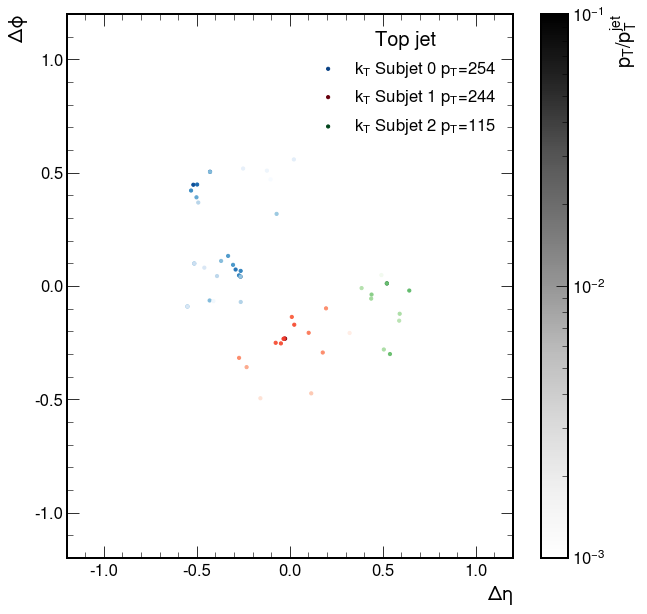

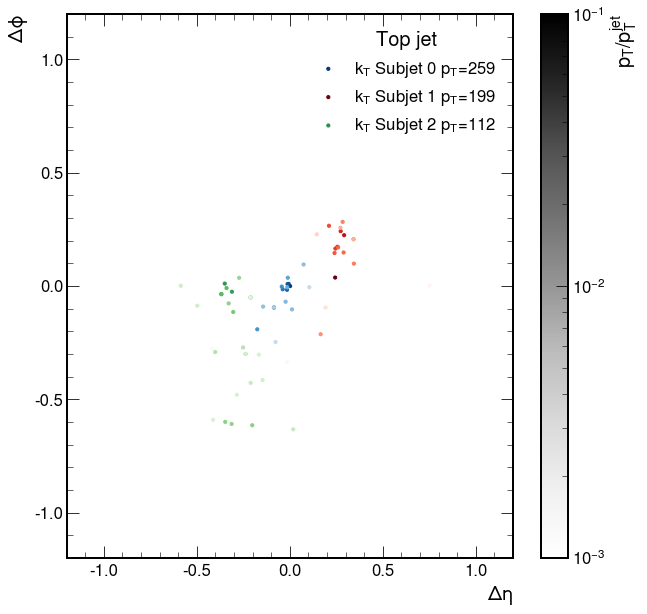

In [37]:
import awkward as ak
import fastjet
import vector
import pandas as pd
import numpy as np

N_SUBJETS = 3

LABEL = {}
LABEL[fastjet.kt_algorithm] = "$k_{{\mathrm{{T}}}}$"
LABEL[fastjet.antikt_algorithm] = "anti-$k_{{\mathrm{{T}}}}$"
LABEL[fastjet.cambridge_algorithm] = "CA"

JET_ALGO = fastjet.kt_algorithm

df = pd.read_hdf("/xai4hepvol/toptagging/test/raw/test.h5", key="table", start=1000, stop=1002)
print(f"{df['is_signal_new'].values=}")


def _col_list(prefix, max_particles=200):
    return ["%s_%d" % (prefix, i) for i in range(max_particles)]


vector.register_awkward()
px = ak.from_regular(ak.from_numpy(df[_col_list("PX")].values), axis=-1)
py = ak.from_regular(ak.from_numpy(df[_col_list("PY")].values), axis=-1)
pz = ak.from_regular(ak.from_numpy(df[_col_list("PZ")].values), axis=-1)
e = ak.from_regular(ak.from_numpy(df[_col_list("E")].values), axis=-1)
mask = e > 0

array = ak.zip(
    {
        "px": px[mask],
        "py": py[mask],
        "pz": pz[mask],
        "E": e[mask],
        "mask": mask[mask],
        "particle_idx": ak.local_index(px[mask]),
        "subjet_idx": ak.zeros_like(px[mask], dtype=int) - 1,
    },
    with_name="Momentum4D",
)

pseudojets = []
for jet in array:
    pseudojets.append(
        [
            fastjet.PseudoJet(particle.px, particle.py, particle.pz, particle.E)
            for particle in jet
        ]
    )
print(f"{len(pseudojets)=}")
print(f"{len(pseudojets[0])=}")


jetdef = fastjet.JetDefinition(JET_ALGO, 0.8)

subjet_indices = []
mapping = array.subjet_idx.to_list()
for ijet, pseudojet in enumerate(pseudojets):
    subjet_indices.append([])
    cluster = fastjet.ClusterSequence(pseudojet, jetdef)

    # cluster jets
    jets = cluster.inclusive_jets()
    print(f"{len(jets)=}")
    assert len(jets) == 1

    # get the 3 exclusive jets
    subjets = cluster.exclusive_subjets(jets[0], N_SUBJETS)
    print(f"{len(subjets)=}")
    assert len(subjets) == N_SUBJETS

    # sort by pt
    subjets = sorted(subjets, key=lambda x: x.pt(), reverse=True)

    for subjet_idx, subjet in enumerate(subjets):
        subjet_indices[-1].append([])
        for subjet_const in subjet.constituents():
            for idx, jet_const in enumerate(pseudojet):
                if (
                    subjet_const.px() == jet_const.px()
                    and subjet_const.py() == jet_const.py()
                    and subjet_const.pz() == jet_const.pz()
                    and subjet_const.E() == jet_const.E()
                ):
                    subjet_indices[-1][-1].append(idx)

    for subjet_idx, subjet in enumerate(subjets):
        print(subjet_indices[ijet][subjet_idx])
        local_mapping = np.array(mapping[ijet])
        local_mapping[subjet_indices[ijet][subjet_idx]] = subjet_idx
        mapping[ijet] = local_mapping

# update array
# array.subjet_idx = ak.Array(mapping)
array = ak.zip(
    {
        "px": px[mask],
        "py": py[mask],
        "pz": pz[mask],
        "E": e[mask],
        "mask": mask[mask],
        "particle_idx": ak.local_index(px[mask]),
        "subjet_idx": ak.Array(mapping),
    },
    with_name="Momentum4D",
)

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors

for i, arr in enumerate(array):
    fig = plt.figure()
    jet_vector = vector.obj(
        px=ak.sum(arr.px, axis=-1),
        py=ak.sum(arr.py, axis=-1),
        pz=ak.sum(arr.pz, axis=-1),
        E=ak.sum(arr.E, axis=-1),
    )
    subjet_vectors = [
        vector.obj(
            px=ak.sum(arr.px[arr.subjet_idx == j], axis=-1),
            py=ak.sum(arr.py[arr.subjet_idx == j], axis=-1),
            pz=ak.sum(arr.pz[arr.subjet_idx == j], axis=-1),
            E=ak.sum(arr.E[arr.subjet_idx == j], axis=-1),
        )
        for j in range(0, N_SUBJETS)
    ]

    deta = arr.deltaeta(jet_vector)
    dphi = arr.deltaphi(jet_vector)
    dpt = arr.pt / jet_vector.pt

    for j, cmap in zip(range(0, N_SUBJETS), ["Blues", "Reds", "Greens", "Purples"]):
        plt.scatter(
            deta[arr.subjet_idx == j],
            dphi[arr.subjet_idx == j],
            c=dpt[arr.subjet_idx == j],
            s=10,
            norm=colors.LogNorm(vmin=0.001, vmax=0.1),
            cmap=cmap,
            label=f"{LABEL[JET_ALGO]} Subjet {j} $p_{{\mathrm{{T}}}}$={subjet_vectors[j].pt:.0f}",
        )
    plt.scatter([], [], c=[], cmap="Greys", norm=colors.LogNorm(vmin=0.001, vmax=0.1))
    cbar = plt.colorbar()
    cbar.set_label("$p_{\mathrm{T}} / p_{\mathrm{T}}^{\mathrm{jet}}$")
    plt.xlabel(r"$\Delta\eta$")
    plt.ylabel(r"$\Delta\phi$")
    plt.ylim(-1.2, 1.2)
    plt.xlim(-1.2, 1.2)
    plt.legend(title="Top jet" if df["is_signal_new"].values[i] == 1 else "QCD jet")
    plt.savefig(f"etaphi_{i}.pdf")
    plt.savefig(f"etaphi_{i}.png")